# Flight Delays at Chicago O'Hare International Airport


In this colab, we will be using 4 different machine learning models to try and classify how long a flight is going to be delayed at the Chicago O’Hare International Airport.
Before we get started, if you want this colab to run fast, then set `DEMO` to `True`. If you want to run every line of this colab, set `DEMO` to `False`. 

In [1]:
DEMO = True

###Installing Dependencies
First let’s install all the libraries and dependencies that we need to run our models. 

In [2]:
!pip install tensorflow
!pip install pydotplus
!pip install tensorflow_decision_forests
!pip install matplotlib
!pip install keras-tuner==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00


In [3]:
# install the dependencies
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

import time
import tensorflow_decision_forests as tfdf

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from IPython.display import clear_output

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.metrics import f1_score
from six import StringIO
import pydotplus
from IPython.display import Image 
dot_data = StringIO()
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)





###Class made for Plotting Graphs

In [4]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           

### Loading the dataset
We cleaned up the dataset locally and loaded it on github. Here we are loading the dataset onto this colab from github for additional datapreprocessing. Multiple copies of the dataframes are created since the NN and the trees need the data in different formats. 

In [5]:
# load the dataset
dataset_url = "https://raw.githubusercontent.com/lee-anh/FlightPredictions/main/flightsResult1.csv"
dataset_url1 =  "https://raw.githubusercontent.com/lee-anh/FlightPredictions/main/flightsResult2.csv"

# For NNs 
df = pd.read_csv(dataset_url)
df = df.append(pd.read_csv(dataset_url1))

# For gradient boosted model 
df1 = df.copy()

# look at the headers
data_top = df1.head() 
data_top



,Unnamed: 0,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,WEATHER_DELAY
0,0,14.54,0.0,0.0,0.0,20,32,14,2015,1,1,4,US,602,N197UW,ORD,PHX,500,228.0,1440,748,NaN
1,1,14.54,0.0,0.0,0.0,20,32,14,2015,1,1,4,UA,1500,N30401,ORD,IAH,510,175.0,925,805,NaN
2,2,14.54,0.0,0.0,0.0,20,32,14,2015,1,1,4,NK,409,N509NK,ORD,FLL,530,188.0,1182,938,NaN
3,3,14.54,0.0,0.0,0.0,20,32,14,2015,1,1,4,UA,1167,N66837,ORD,DEN,533,167.0,888,720,NaN
4,4,14.54,0.0,0.0,0.0,20,32,14,2015,1,1,4,EV,5498,N132EV,ORD,DTW,535,85.0,235,800,NaN


### Data Exploration
Before we get started, let's explore the data to see what features might be especially important for predicing flights! To start, we will drop all data points that have NaN values. The we will plot correlations between delay time and weather variables such as min temperature, max temperature, temperature difference, and precipitation. 

MAXIMUM DELAY:  991.0
MINIMUM DELAY:  0.0
AVERAGE DELAY:  6.339243658401212


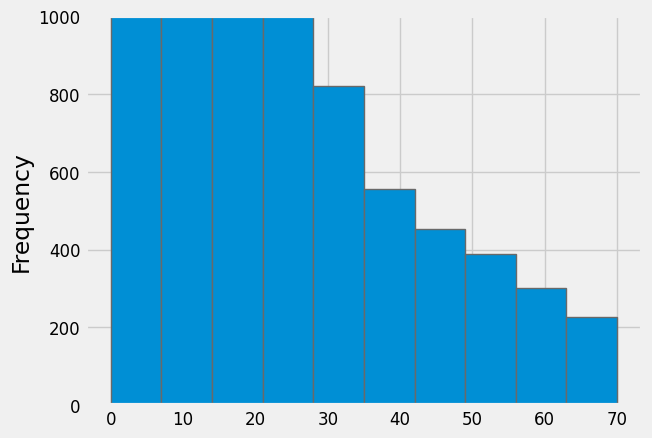

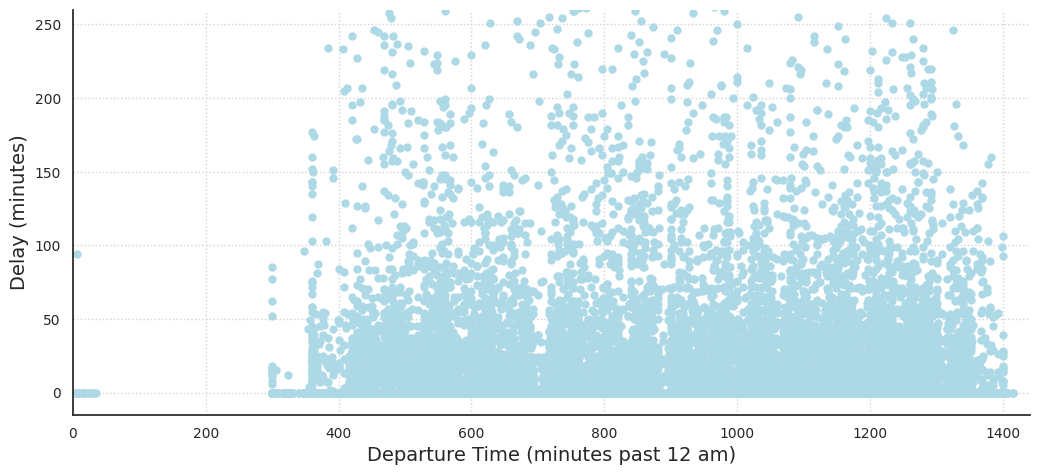

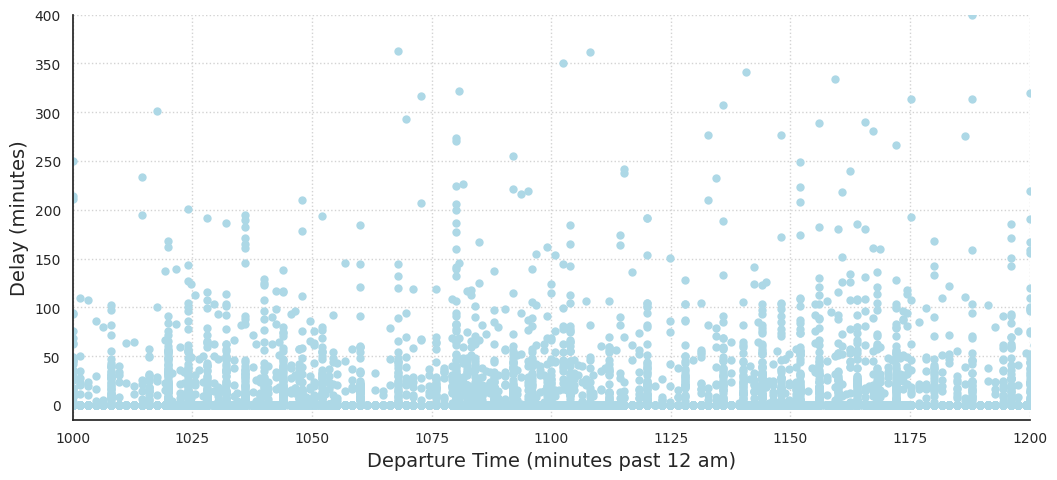

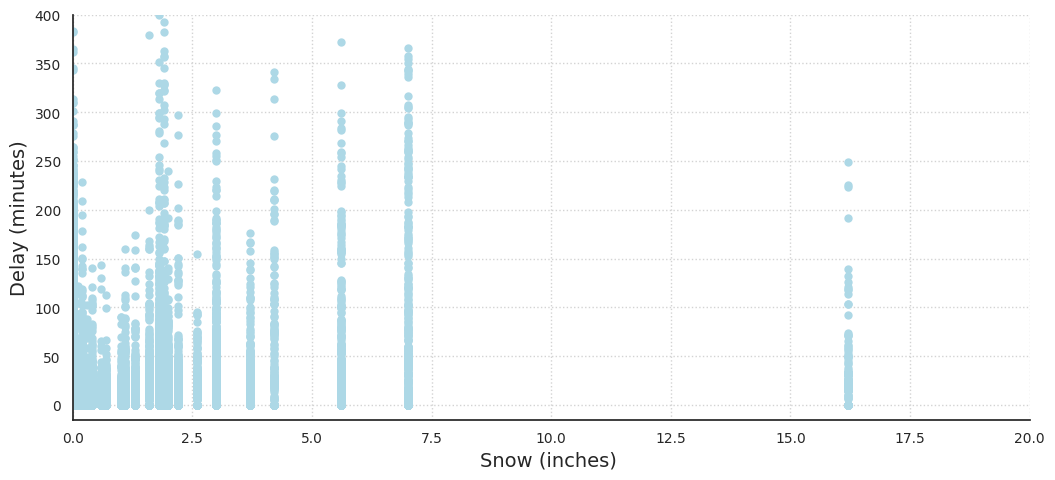

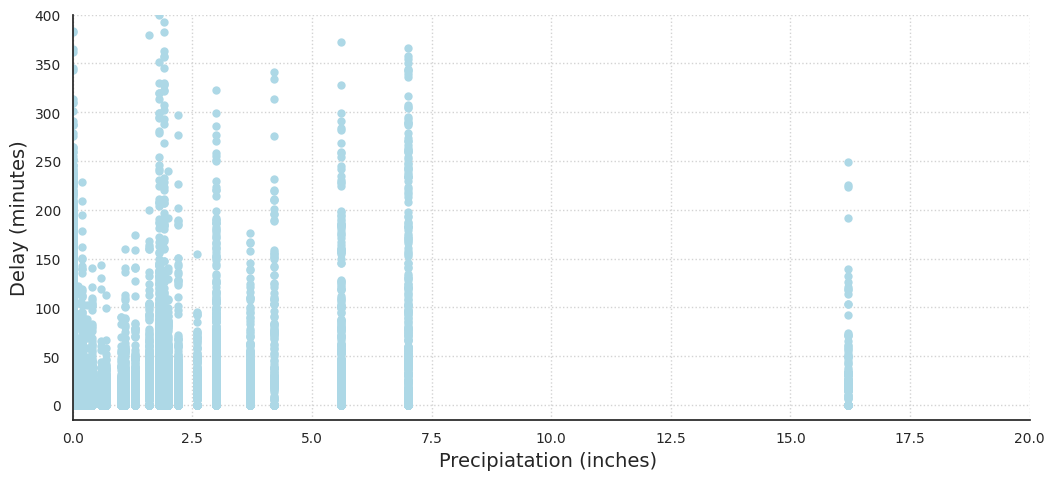

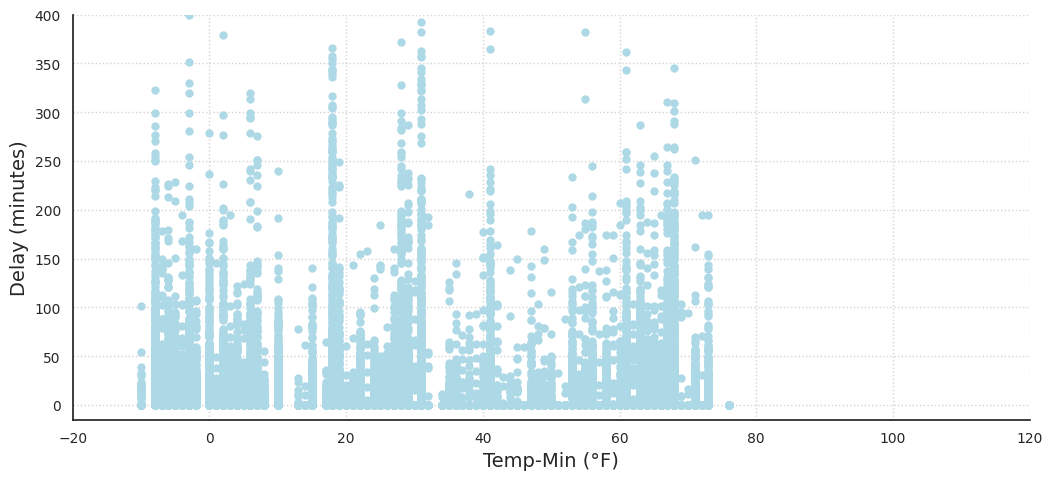

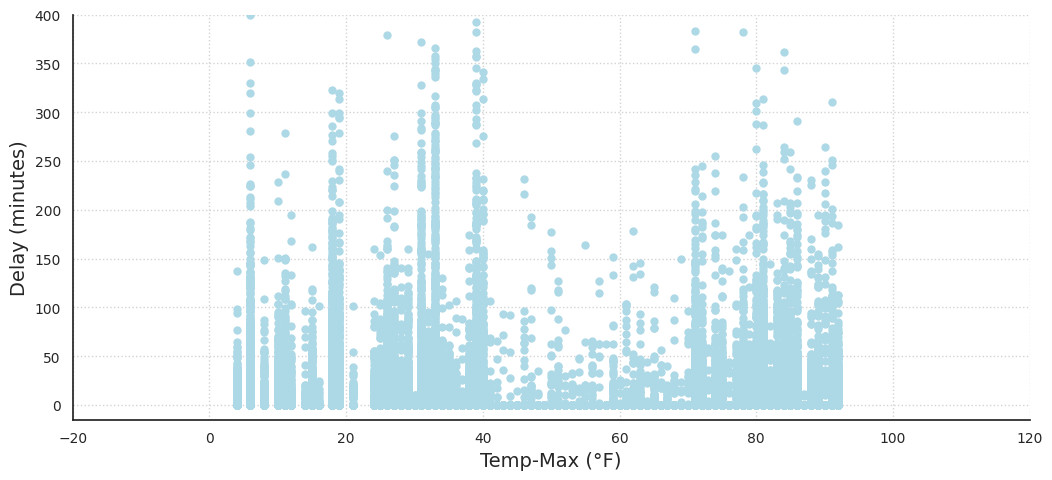

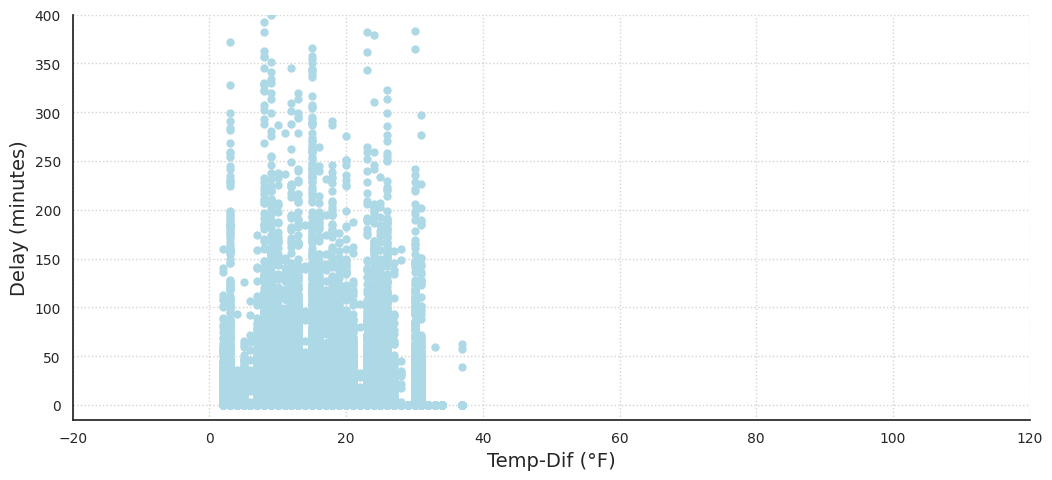

In [6]:
# Check how complete the data is (aka % not NaN)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)


# Clean data to remove Nan values
df = df.dropna()
df = df.reset_index(drop=True)

#Take a look at average weather delay times and their distribution in this dataset
df["WEATHER_DELAY"].plot(kind="hist", range=[0, 70], ylim = (0,1000))
print("MAXIMUM DELAY: ", df["WEATHER_DELAY"].max())
print("MINIMUM DELAY: ", df["WEATHER_DELAY"].min())
print("AVERAGE DELAY: ", df["WEATHER_DELAY"].mean(skipna = True))

# Lets take a look to see how time of day effects the delays in the dataset

# convert scheduled departure to minutes past 12 am
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].map(lambda a : (a % 100) + ((a/100)*60) )

fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df['SCHEDULED_DEPARTURE'], df['WEATHER_DELAY'], label='o')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure Time (minutes past 12 am)', fontsize = 14)
fig1.set_xlim(0, 1440)
fig1.set_ylim(-15, 260)

# This looks interesting, the peak delays seem to have a trace of some patern
# lets look closer 1000 and 1200
fig2 = Figure_style(11, 5, 1, 1)
fig2.pos_update(0, 0)
fig2.cust_scatter(df['SCHEDULED_DEPARTURE'], df['WEATHER_DELAY'], label='o')
fig2.style() 
fig2.set_ylabel('Delay (minutes)', fontsize = 14)
fig2.set_xlabel('Departure Time (minutes past 12 am)', fontsize = 14)
fig2.set_xlim(1000, 1200)
fig2.set_ylim(-15, 400)

# Ok looks like it could be represented by a function 

# Lets look at Delays due to Snow and Precipiatation

fig3 = Figure_style(11, 5, 1, 1)
fig3.pos_update(0, 0)
fig3.cust_scatter(df['SNOW'], df['WEATHER_DELAY'], label='o')
fig3.style() 
fig3.set_ylabel('Delay (minutes)', fontsize = 14)
fig3.set_xlabel('Snow (inches) ', fontsize = 14)
fig3.set_xlim(0, 20)
fig3.set_ylim(-15, 400)

fig4 = Figure_style(11, 5, 1, 1)
fig4.pos_update(0, 0)
fig4.cust_scatter(df['SNOW'], df['WEATHER_DELAY'], label='o')
fig4.style() 
fig4.set_ylabel('Delay (minutes)', fontsize = 14)
fig4.set_xlabel('Precipiatation (inches) ', fontsize = 14)
fig4.set_xlim(0, 20)
fig4.set_ylim(-15, 400)

# Let's look at temp
fig5 = Figure_style(11, 5, 1, 1)
fig5.pos_update(0, 0)
fig5.cust_scatter(df['TMIN'], df['WEATHER_DELAY'], label='o')
fig5.style() 
fig5.set_ylabel('Delay (minutes)', fontsize = 14)
fig5.set_xlabel('Temp-Min (°F)', fontsize = 14)
fig5.set_xlim(-20, 120)
fig5.set_ylim(-15, 400)

# INTERESTING SEEMS LIKE A PARABOLA LIKE SHAPE
fig6 = Figure_style(11, 5, 1, 1)
fig6.pos_update(0, 0)
fig6.cust_scatter(df['TMAX'], df['WEATHER_DELAY'], label='o')
fig6.style() 
fig6.set_ylabel('Delay (minutes)', fontsize = 14)
fig6.set_xlabel('Temp-Max (°F)', fontsize = 14)
fig6.set_xlim(-20, 120)
fig6.set_ylim(-15, 400)

# SAME HERE
fig7 = Figure_style(11, 5, 1, 1)
fig7.pos_update(0, 0)
fig7.cust_scatter(df['TMAX'] - df['TMIN'] , df['WEATHER_DELAY'], label='o')
fig7.style() 
fig7.set_ylabel('Delay (minutes)', fontsize = 14)
fig7.set_xlabel('Temp-Dif (°F)', fontsize = 14)
fig7.set_xlim(-20, 120)
fig7.set_ylim(-15, 400)




### Data Preprocessing
We must process the data differently for NN and for our tree based models. 

For the NNs, we will one-hot the categorical data such as the location of the flight and the name of the airport it is flying to. Our `y` (the WEATHER_DELAYs) need to be separated out from the input `X` and then classified into 9 classes, which are time brackets. Then we split the data into our training, validation, and test sets. 

For the trees, we specify the target variable using `label` and there is no need so separate it out. We classify `y` into 9 separate classes, just as we did for the NNs. Then We create 2 different traininging, validation, and test sets. One set will be used by the Gradient Boosted Tree model and the other will be used by the Random Forest Model. A different ratio is needed for the Random Forest model because it takes a long time to run. 

In [7]:
# DATA PREPROCESSING 

##################### For NN ####################################
def OneHot(df, name):
  df["DESTINATION_AIRPORT"] = df["DESTINATION_AIRPORT"].astype('category')
  df['Gen_new'] = df["DESTINATION_AIRPORT"].cat.codes
  df["AIRLINE"] = df["AIRLINE"].astype('category')
  df['Air_new'] = df["AIRLINE"].cat.codes
  # Create an instance of One-hot-encoder
  enc = OneHotEncoder()
  
# Passing encoded columns
  enc_data = pd.DataFrame(enc.fit_transform(
    df[['Gen_new','Air_new']]).toarray())
  
  # Merge with main
  New_df = df.join(enc_data)
  New_df = New_df.drop("Gen_new", axis='columns')
  New_df = New_df.drop("DESTINATION_AIRPORT", axis='columns')
  New_df = New_df.drop("Air_new", axis='columns')
  New_df = New_df.drop("AIRLINE", axis='columns')
  return New_df


# drop the first column, which is just an enumeration 
df.drop(columns=df.columns[0], axis=1,  inplace=True)

# this helper function classsifies the delays into 9 different classes 
def classify_delays(dt):
    if(dt < 1): 
        return 0
    elif(dt < 4):
        return 1
    elif(dt < 11):
        return 2
    elif(dt < 17):
        return 3
    elif(dt < 25):
        return 4
    elif (dt < 37):
        return 5
    elif (dt < 59):
        return 6
    elif (dt < 130):
        return 7
    else:
        return 8


y = df["WEATHER_DELAY"].map(classify_delays ) 


df = df.drop(["TAIL_NUMBER"], axis="columns")
df = df.drop(["ORIGIN_AIRPORT"], axis="columns")

# Onehotting every categorical var
df = OneHot(df, "DESTINATION_AIRPORT")

# X
df.columns = df.columns.astype(str)
X = df.drop(["WEATHER_DELAY"], axis="columns")

# split the dataset to train, validation, and test - numpy format 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)


X_train=np.asarray(X_train).astype(int)
X_val=np.asarray(X_val).astype(int)



#####################  gbt and random forest ###########################
label = "WEATHER_DELAY"

# change delays to 9 classes 
df1[label] = df1[label].map(classify_delays) 

# drop the first column, which is just an enumeration 
df1.drop(columns=df1.columns[0], axis=1,  inplace=True)
df1 = df1.drop(["ORIGIN_AIRPORT"], axis="columns")

# split the dataset to train, validation, and test - pandas format 
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

# df2 will be a copy for the random forest model 
df2 = df1.copy()


# gbt 
ds_pd_train, ds_pd_test = split_dataset(df1, 0.2)
ds_pd_test_y = ds_pd_test[label]
ds_pd_train, ds_pd_val= split_dataset(ds_pd_train, 0.25)
print("For XGB: {} examples in training, {} examples for testing, {} examples in validation.".format(
    len(ds_pd_train), len(ds_pd_val), len(ds_pd_test)))

# random forest 
ds_pd_train2, ds_pd_test2 = split_dataset(df2, 0.2)
ds_pd_train2, ds_pd_val2= split_dataset(ds_pd_train2, 0.95)
print("For Random Forest: {} examples in training, {} examples for testing, {} examples in validation.".format(
    len(ds_pd_train2), len(ds_pd_val2), len(ds_pd_test2)))


# convert to tensorflow datasets
ds_train = tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_train, label=label)
ds_test = tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_test, label=label)
ds_val =  tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_val, label=label)

# convert to tensorflow datasets
ds_train2 = tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_train2, label=label)
ds_test2 = tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_test2, label=label)
ds_val2 =  tfdf.keras.pd_dataframe_to_tf_dataset(ds_pd_val2, label=label)



For XGB: 171536 examples in training, 57338 examples for testing, 57010 examples in validation.
For Random Forest: 11681 examples in training, 217356 examples for testing, 56847 examples in validation.


## Our Models
In this section we will be training and tuning multiple types of models: 
- NN
- Gradient Boosted Tree
- Random Forest 
- KNN


### Neural Network Model


In [8]:
# FUNCTION TO RUN MODEL

def runModel(hidden_layers, LR, neurons):
  # Specify the model.
  # NEURAL NETWORK MODEL
  encoder = OneHotEncoder()

  encoded_Y_train = encoder.fit(y_train.values.reshape(-1,1))
  encoded_Y_train = encoded_Y_train.transform(y_train.values.reshape(-1,1)).toarray()
  encoded_Y_val = encoder.fit(y_val.values.reshape(-1,1))
  encoded_Y_val = encoded_Y_val.transform(y_val.values.reshape(-1,1)).toarray()


  simple_model = keras.models.Sequential()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

  simple_model.add(keras.layers.Dense(190, activation = 'tanh', kernel_regularizer='l1_l2'))
  simple_model.add(Dropout(0.2))
  for i in range(1,hidden_layers-5):
    if (i % 2 == 0):
      simple_model.add(keras.layers.Dense(neurons, activation = 'tanh', kernel_regularizer='l1_l2'))
      simple_model.add(Dropout(0.2))
    else:
      simple_model.add(keras.layers.Dense(neurons, activation = 'relu', kernel_regularizer='l1_l2'))
      simple_model.add(Dropout(0.2))
  simple_model.add(keras.layers.Dense(9, activation = 'softmax'))

  opt = keras.optimizers.Adam(learning_rate= LR)

  simple_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['categorical_accuracy'])
  simple_model.summary
  history  = simple_model.fit(X_train, encoded_Y_train, epochs=10, validation_data=(X_val, encoded_Y_val),callbacks=[es])

  return  simple_model, max(history.history['val_categorical_accuracy'])


###Hyperparameter Tuning for NN

In [9]:
#TUNING NN Model for optimal amout of hidden layers

def repeat_List(a,x):
  return list(np.repeat(a,x))

if (not DEMO):
  list_valac = []
  hidden_layers = np.arange(1, 14, 2).tolist()
  neurons = np.arange(30, 290, 20).tolist()
  max_hid = hidden_layers[0]
  max_neurons = neurons[0] 
  max_acc = 0.0



  for h in hidden_layers:
  
    for l in neurons:
      model, score = runModel(h,0.01, l)
      list_valac.append(score)
      if (score > max_acc):
       max_acc = score
       max_hid = h
       max_neurons = l




# plotting
  fig = plt.figure()

  ax = plt.axes(projection ='3d')

  print(" hidden layers")
  print(hidden_layers)
  print("Neurons")
  print(neurons)
  print("Val accuracy")
  print(list_valac)
  ax.plot3D(repeat_List(hidden_layers, len(neurons)), repeat_List(neurons, len(hidden_layers)), list_valac, 'green')
  ax.set_title('3D line plot Hyper-Parameter Tuning')
  ax.set_xlabel("# of Hidden Layers")
  ax.set_ylabel("# of Nuerons")
  ax.set_zlabel("Val Accuracy")
  plt.show()





###Optimal NN model

In [10]:
model, score = runModel(11,0.01, 50)

print("Val Accuracy:")
print(score)

#formatting test vals 

encoder = OneHotEncoder()

encoded_Y_test = encoder.fit(y_test.values.reshape(-1,1))
encoded_Y_test = encoded_Y_test.transform(y_test.values.reshape(-1,1)).toarray()

test_loss, test_accuracy = model.evaluate(X_test, encoded_Y_test)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Load the trained model

# Get the test set predictions
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Compute the F1 score for the test set
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score", f1)


Epoch 1/10
1250/1250 [==============================] - 32s 15ms/step - loss: 1.7646 - categorical_accuracy: 0.8611 - val_loss: 1.4150 - val_categorical_accuracy: 0.8564
Epoch 2/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4036 - categorical_accuracy: 0.8614 - val_loss: 1.4175 - val_categorical_accuracy: 0.8564
Epoch 2: early stopping
Val Accuracy:
0.856446385383606
417/417 [==============================] - 1s 3ms/step - loss: 1.4025 - categorical_accuracy: 0.8606
Test Loss: 1.4024794101715088
Test Accuracy: 0.8606465458869934
417/417 [==============================] - 1s 2ms/step
f1 score 0.7961882274241636


### Gradient Boosted Trees
We will now try to use a Graident Boosted Tree. The Gradient Boosted tree trains multiple tree where new trees correct for the errors in previous trees. This is especially beneficial for our use case because over the course of the year, flight routes are repeated by the same airlines and some of these flights are delayed and others aren't so the cause of the delay coule be more subtle and the gradient boosted trees could capture these subtleties. 

We also use the hyperparemeter_template of "benchmark_rank1", which is the template suggested by the official TensorFlow documentation. 

In [11]:
# Gradient Boosted Tree with 9 classes 

if (not DEMO):
  tuner = tfdf.tuner.RandomSearch(num_trials=10)


  model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
  model_1.fit(ds_train)



In [12]:
# GBT analytics 
if (not DEMO):
  
  
  print(model_1.summary())

  tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)
  model_1.compile(metrics=["accuracy"])
  evaluation = model_1.evaluate(ds_test, return_dict=True)


  for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

  print("input features")
  model_1.make_inspector().features()

  print("feature importance")
  model_1.make_inspector().variable_importances()
  # Load the trained model

  # F1 Score 
  y_pred = model_1.predict(ds_test)
  

 # Convert the predicted probabilities to class labels
  y_pred = np.argmax(y_pred, axis=1)
  y_true = [y for x, y in ds_test]
  y_true = tf.concat(y_true, axis=0).numpy() 
  f1 = f1_score(y_true, y_pred, average="weighted")
  print("F1 score:", f1) 




In [14]:
# GBT plot
if (not DEMO):
  tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

In [16]:
# GBT graph 
import matplotlib.pyplot as plt

if (not DEMO):
  logs = model_1.make_inspector().training_logs()

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
  plt.xlabel("Number of trees")
  plt.ylabel("Accuracy (out-of-bag)")

  plt.subplot(1, 2, 2)
  plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
  plt.xlabel("Number of trees")
  plt.ylabel("Logloss (out-of-bag)")

  plt.show()
  


### Random Forest Model 
Random forest models train multiple trees at once. These trees are forced to pick from a random subset of features which diversifies them. Together, the trees create a forest that is collectively more stable and potentially more accurate than the rest of the trees. A major disadvantage of random forest models is that they take a long time to train. We trained our random forest model on a subset (~20%) of the training data. 


In [ ]:
# Random forest 
model_2 = tfdf.keras.RandomForestModel(verbose=1)

# Train the model.
model_2.fit(ds_train2)

Use /tmp/tmp205apdev as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.170207. Found 11681 examples.
Training model...


In [ ]:
# Random forest analytics 

print("model summary")
model_2.summary()

print("input features")
model_2.make_inspector().features()

print("feature importance")
model_2.make_inspector().variable_importances()

print("training logs")
model_2.make_inspector().training_logs()

y_pred = model_1.predict(ds_test2)
  
model_2.compile(metrics=["accuracy"])
evaluation = model_2.evaluate(ds_test2, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")



 # Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)
y_true = [y for x, y in ds_test2]
y_true = tf.concat(y_true, axis=0).numpy() 
f1 = f1_score(y_true, y_pred, average="weighted")
print("F1 score:", f1) 

In [ ]:
# Random forest tree plot
tfdf.model_plotter.plot_model_in_colab(model_2, tree_idx=0, max_depth=3)

In [ ]:
# Random forest Graph 

logs = model_2.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

###KNN Model With Hyperparameter Tuning

In [ ]:

#knn model



#HYPER PARAMETER TUNING FOR THE k VALUE

k_values = [i for i in range (1,20)]
scores = []
#df.drop(["WEATHER_DELAY"], axis="columns")

#REDUCIING SAMPLE SIZE SO TREE TAKES LESS PROCESSING POWER
Xf = df.sample(n=50000)
Xf = Xf.dropna()
Xf = Xf.reset_index(drop = True)
X = Xf.drop(["WEATHER_DELAY"], axis="columns")
y = Xf["WEATHER_DELAY"]


scaler = StandardScaler()
X = scaler.fit_transform(X)


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")





###Optimal KNN Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
score = cross_val_score(knn, X, y, cv=5)
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy score", accuracy)
# Compute the F1 score for the test set
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score", f1)